# Classification of heating types using smart meter data

This script loads data from one week of residential electricity consumption and class labels for the heating type. The data and the approach originates from the paper ["Detection of heat pumps from smart meter and open data" by Weigert et al. (2020)](https://doi.org/10.1186/s42162-020-00124-6).

A skelton for the analysis is provided and will be discussed in the tutorial. The task for the following week will be to extend this script by various aspects independently.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Prepare the data
Load the dataset from the data folder in Github. One file contains the smart meter readings. They have a 15-minute granularity and the data covers one week. Each row in the data contains the electricity consumption of one household and for every household there are 672 measurements available. The other file contains ground truth data on data related to the household type and heating system. They were obtained using a survey and they are the labels for our classification.

Please inspect the data and check it for errors.

In [2]:
labels = pd.read_csv("data/heatinginfo_pseudonymized.csv", sep=";")
cons = pd.read_csv("data/smartmeter_cons_W44.csv", sep=";", decimal=",")

In [3]:
#merge data together
df_joined = pd.merge(labels, cons, left_on="VID", right_on="Unnamed: 0", how="inner")

#remove unnecessary columns for now
df_joined = df_joined.drop(['survey_WP_type', 'survey_WP_age', 'household_type', 'Unnamed: 0', 'VID'], axis=1).copy()

In [4]:
df_joined.dtypes

heating_type     object
V1              float64
V2              float64
V3              float64
V4              float64
                 ...   
V668            float64
V669            float64
V670            float64
V671            float64
V672            float64
Length: 673, dtype: object

In [5]:
df_joined['V1'].describe()

count    537.000000
mean       0.429253
std        0.786094
min        0.000000
25%        0.040000
50%        0.140000
75%        0.550000
max       11.210000
Name: V1, dtype: float64

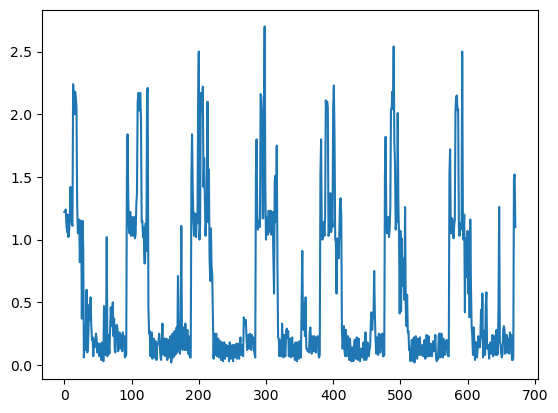

In [7]:
values = df_joined.iloc[4, 1:] #select one row (first parameter) and select all columns without thefirst column
#values.
plt.plot(range(0, 672), values) 
#plot(cons[1])
plt.show()

In [8]:
#omit cases where we have no data on heating types
data_complete = df_joined[~df_joined['heating_type'].isna()].copy()
data_complete['heating_type']

1             heat pump
2             heat pump
4      electric heating
12            heat pump
14     electric heating
             ...       
511           heat pump
515    electric heating
517           heat pump
522           heat pump
523           heat pump
Name: heating_type, Length: 152, dtype: object

## Define the dependent variable and create data frame for next steps

In [12]:
# Change the data type of the dependent variable 'heating type' and create new data frame
df_features = pd.DataFrame({'heating_type': data_complete['heating_type'].astype('category')})
df_features['heating_type']

# optional task 5: redefine the dependent variable and use less than 4 categories, then you can also use more than four fold in the cross-validation.

1             heat pump
2             heat pump
4      electric heating
12            heat pump
14     electric heating
             ...       
511           heat pump
515    electric heating
517           heat pump
522           heat pump
523           heat pump
Name: heating_type, Length: 152, dtype: category
Categories (4, object): ['electric heating', 'heat pump', 'heat pump and boiler', 'other']

## Feature extraction

The raw data has a very high dimensionality (4 measurements / hour, 24h / day lead to 672 measurements for a week), and we see that there are recurrent pattern in the data. This suggestst that we should invest some time in feature extraction. 

Read the paper by [Beckel et al (2014)](https://doi.org/10.1016/j.energy.2014.10.025) and [Hopf et al. (2018)](https://dx.doi.org/10.1007/s12525-018-0290-9) to get an inspiration of which features can be extracted from smart meter data. Below are 18 features already implemented. 

**Task 1:** Extract additional 10 features from the smart meter readings. You can define your own features or refer to features described in one of the papers 

In [13]:
# Just use the smart meter data for the computation
smd = data_complete.drop('heating_type', axis=1).copy()

# Features (1) Consumption c
df_features['c_total']   = smd.mean(axis=1)
df_features['c_weekday'] = smd.iloc[:, :480].mean(axis=1)
df_features['c_weekend'] = smd.iloc[:, 481:672].mean(axis=1)
df_features['c_morning'] = smd.iloc[:, np.r_[24:35, 120:131, 216:227, 312:323, 408:419]].mean(axis=1)
df_features['c_day']     = smd.iloc[:, np.r_[36:75, 132:172, 228:268, 324:364, 420:460]].mean(axis=1)
df_features['c_noon']     = smd.iloc[:, np.r_[46:55, 142:151, 238:247, 334:343, 430:439]].mean(axis=1)
df_features['c_evening'] = smd.iloc[:, np.r_[76:89, 125:185, 221:281, 317:377, 413:473]].mean(axis=1)
df_features['c_night']    = smd.iloc[:, np.r_[90:95, 186:191, 282:287, 378:383, 474:479]].mean(axis=1)
df_features['c_max']     = smd.iloc[:, 1:337].max(axis=1)
df_features['c_min']     = smd.iloc[:, 1:337].min(axis=1)

df_features['r_mean_max'] = df_features['c_total'] / df_features['c_max']
df_features['r_min_mean'] = df_features['c_min'] / df_features['c_max']
df_features['r_morning_noon'] = df_features['c_morning'] / df_features['c_noon']
df_features['r_weekday_weekend'] = df_features['c_weekday'] / df_features['c_weekend']

# Temporal properties
df_features['t_above_0.5kw'] = (smd.iloc[:, 1:480] > 0.5).sum(axis=1) / 480
df_features['t_above_1kw']  = (smd.iloc[:, 1:480] > 1).sum(axis=1) / 480
df_features['t_above_2kw'] = (smd.iloc[:, 1:480] > 2).sum(axis=1) / 480
df_features['t_above_mean']  = smd.iloc[:, 1:480].apply(lambda x: (x > x.mean()).sum(), axis=1) / 480

df_features['s_variance'] = smd.iloc[:, :480].var(axis=1)

# task 1: implement further features here

#df_features.columns
feature_labels = ['c_total', 'c_weekday', 'c_weekend', 'c_morning', 'c_night',
                  'c_day', 'c_evening', 'c_noon', 'c_max', 'c_min', 'r_mean_max',
                  'r_min_mean', 'r_morning_noon', 'r_weekday_weekend', 't_above_0.5kw',
                  't_above_1kw', 't_above_2kw', 't_above_mean', 's_variance']

#df_features.shape
df_features.dtypes

heating_type         category
c_total               float64
c_weekday             float64
c_weekend             float64
c_morning             float64
c_day                 float64
c_evening             float64
c_noon                float64
c_max                 float64
c_min                 float64
r_mean_max            float64
r_min_mean            float64
r_morning_noon        float64
r_weekday_weekend     float64
t_above_0.5kw         float64
t_above_1kw           float64
t_above_2kw           float64
t_above_mean          float64
s_variance            float64
dtype: object

## Prepare the features for ML

Lets have a look at the features and see if we need to make any data preparations.

In [14]:
df_features.describe()

,c_total,c_weekday,c_weekend,c_morning,c_day,c_evening,c_noon,c_max,c_min,r_mean_max,r_min_mean,r_morning_noon,r_weekday_weekend,t_above_0.5kw,t_above_1kw,t_above_2kw,t_above_mean,s_variance
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,149.000000,148.000000,148.000000,149.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.253188,0.255941,0.245381,0.253009,0.176306,0.186246,0.325454,1.673688,0.025550,inf,0.020513,2.460240,1.081740,0.158978,0.060211,0.016228,0.275343,0.202742
std,0.212354,0.218981,0.200860,0.274349,0.173375,0.187028,0.473254,1.236115,0.061792,NaN,0.064610,5.522677,0.418232,0.162730,0.080635,0.042431,0.139918,0.416530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021714,0.000000,0.000492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.081210,0.074745,0.068678,0.041591,0.033869,0.038834,0.036500,0.835000,0.000000,0.099832,0.000000,0.606402,0.957606,0.026563,0.000000,0.000000,0.178646,0.016574
50%,0.239821,0.237172,0.235576,0.185091,0.124548,0.129348,0.174760,1.455000,0.010000,0.147112,0.007314,1.008838,1.050374,0.134375,0.030208,0.000000,0.286458,0.088985
75%,0.365634,0.365990,0.360838,0.403682,0.289945,0.305166,0.427100,2.372500,0.030000,0.208891,0.019494,1.778288,1.194383,0.252604,0.094271,0.010417,0.369792,0.180341
max,1.385521,1.387634,1.374392,2.064000,0.850050,0.936026,3.400800,6.580000,0.667590,inf,0.700000,39.772727,3.557762,0.997917,0.468750,0.381250,0.781250,3.138431


In [15]:
#fractions may lead to infinite values and other computations may lead to missing values. For simpliciy, we replace all with 0
df_features.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
#df_features = df_features.fillna({'r_mean_max':0})

#check if the errors are fixed
df_features.describe()
#df_features.head(20)

,c_total,c_weekday,c_weekend,c_morning,c_day,c_evening,c_noon,c_max,c_min,r_mean_max,r_min_mean,r_morning_noon,r_weekday_weekend,t_above_0.5kw,t_above_1kw,t_above_2kw,t_above_mean,s_variance
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.253188,0.255941,0.245381,0.253009,0.176306,0.186246,0.325454,1.673688,0.025550,0.215627,0.019973,2.395497,1.060390,0.158978,0.060211,0.016228,0.275343,0.202742
std,0.212354,0.218981,0.200860,0.274349,0.173375,0.187028,0.473254,1.236115,0.061792,0.523991,0.063834,5.463345,0.440717,0.162730,0.080635,0.042431,0.139918,0.416530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.081210,0.074745,0.068678,0.041591,0.033869,0.038834,0.036500,0.835000,0.000000,0.093716,0.000000,0.567586,0.950558,0.026563,0.000000,0.000000,0.178646,0.016574
50%,0.239821,0.237172,0.235576,0.185091,0.124548,0.129348,0.174760,1.455000,0.010000,0.144478,0.007234,0.998534,1.039976,0.134375,0.030208,0.000000,0.286458,0.088985
75%,0.365634,0.365990,0.360838,0.403682,0.289945,0.305166,0.427100,2.372500,0.030000,0.204637,0.018850,1.724227,1.185229,0.252604,0.094271,0.010417,0.369792,0.180341
max,1.385521,1.387634,1.374392,2.064000,0.850050,0.936026,3.400800,6.580000,0.667590,6.193452,0.700000,39.772727,3.557762,0.997917,0.468750,0.381250,0.781250,3.138431


## Classification and evaluation with cross-validation

Below is a straightforward implementation of a cross-validation to evaluate different ML models for the prediction of the heating type. You see that two ML models are implemented: k Nearest Neighbor (kNN) and Support Vector Machine (SVM). In addition, accuracy is implemented as a simple error metric.

**Task 2:** Select 2-3 additional ML algorithms from scikit learn, probably some that are more efficient (e.g., ensemble / boosting methods).

**Task 2:** Extend the evaluation by also calculating Precision, Recall, and AUC. 

**Task 3:** Visualize and interpret the results of the different classifier.


In [16]:

accuracies_knn = []
accuracies_svm = []
#implement further performance metrics here...

# Splitting the data into training and testing sets (70:30 split)
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for train_index, test_index in kf.split(df_features, df_features['heating_type']):
    train_data = df_features.iloc[train_index]
    test_data = df_features.iloc[test_index]
    
    train_features = train_data[feature_labels]
    test_features = test_data[feature_labels]
    
    train_labels = train_data['heating_type']
    test_labels = test_data['heating_type']
    
    # Train and evaluate kNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(train_features, train_labels)
    knn_predictions = knn_model.predict(test_features)
    accuracies_knn.append(accuracy_score(test_labels, knn_predictions))
    
    # Train and evaluate SVM model
    svm_model = SVC(kernel='rbf')
    svm_model.fit(train_features, train_labels)
    svm_predictions = svm_model.predict(test_features)
    accuracies_svm.append(accuracy_score(test_labels, svm_predictions))

    # evaluate further classifier here...
    
# Calculate average accuracies
average_accuracy_knn = np.round(np.mean(accuracies_knn), 4)
sd_accuracy_knn      = np.round(np.std(accuracies_knn), 4)
average_accuracy_svm = np.round(np.mean(accuracies_svm), 4)
sd_accuracy_svm      = np.round(np.std(accuracies_svm), 4)

# Print results
print(f"KNN Accuracy: M={average_accuracy_knn} (SD={sd_accuracy_knn})")
print(f"SVM Accuracy: M={average_accuracy_svm} (SD={sd_accuracy_svm})")


KNN Accuracy: M=0.5592 (SD=0.0342)
SVM Accuracy: M=0.6118 (SD=0.0342)


In [17]:
#accuracies_knn
accuracies_svm

[0.631578947368421, 0.631578947368421, 0.631578947368421, 0.5526315789473685]